In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams ['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family']= 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3
matplotlib.rcParams['figure.facecolor'] = (1,1,1)

In [2]:
signals_mc_spec = [ # name, weight, energy, ewidth, radius, rwidth
    ('A',10,3,1,3,1),
    ('B',10,3,1,7,1),
    ('C',10,7,1,3,1),
    ('D',10,7,1,7,1)
]

poisson_means = [200,100,100,50]

def gen_fake(filename,energy,ewidth,radius,rwidth,num=10000):
    e = np.random.normal(energy,ewidth,num)
    r = np.random.normal(radius,rwidth,num)
    data = np.asarray([e,r]).T
    if filename:
        np.save(filename,data)
    else:
        return data
    
for name, weight, energy, ewidth, radius, rwidth in signals_mc_spec:
    for i in range(weight):
        gen_fake('data/%s_%i.npy'%(name,i),energy, ewidth, radius, rwidth)

for i in range(250):
    means = np.random.poisson(poisson_means)
    data = []
    for j, (name, weight, energy, ewidth, radius, rwidth) in enumerate(signals_mc_spec):
        s_data = gen_fake(None, energy, ewidth, radius, rwidth, num=means[j])
        data.append(s_data)
    data = np.concatenate(data)
    np.save('data/raw_data_%i.npy'%i,data)

In [3]:
from kdfit.calculate import System
from kdfit.analysis import Analysis
from kdfit.data import NPYData

In [4]:
a = Analysis()
obs = a.add_observables('Scint_Phase',binning=21) #21 bins per dimension!
e_scale,e_shift,e_res = obs.add_dimension('Energy',0,10)
r_scale,r_shift,r_res = obs.add_dimension('Radius',0,10)
A_sig = obs.add_signal('A_pdf')
B_sig = obs.add_signal('B_pdf')
C_sig = obs.add_signal('C_pdf')
D_sig = obs.add_signal('D_pdf')

In [5]:
mc_files = dict(Scint_Phase=dict(A_pdf=NPYData('A_mc_loader',glob('data/A_*.npy'),indexes=[0,1]),
                                B_pdf=NPYData('B_mc_loader',glob('data/B_*.npy'),indexes=[0,1]),
                                C_pdf=NPYData('C_mc_loader',glob('data/C_*.npy'),indexes=[0,1]),
                                D_pdf=NPYData('D_mc_loader',glob('data/D_*.npy'),indexes=[0,1])))
a.load_mc(mc_files)

In [6]:
a.load_data(dict(Scint_Phase=NPYData('data_loader',['data/raw_data_0.npy'],indexes=[0,1])))

In [7]:
A_sig.nev_param.value = poisson_means[0]
A_sig.nev_param.fixed = False
B_sig.nev_param.value = poisson_means[1]
B_sig.nev_param.fixed = False
C_sig.nev_param.value = poisson_means[2]
C_sig.nev_param.fixed = False
D_sig.nev_param.value = poisson_means[3]
D_sig.nev_param.fixed = False
a.create_likelihood(verbose=True)

Ouput Values: [Total_Likelihood]
Scint_Phase_BinnedLikelihood => Total_Likelihood
A_pdf_nev => Scint_Phase_BinnedLikelihood
B_pdf_nev => Scint_Phase_BinnedLikelihood
C_pdf_nev => Scint_Phase_BinnedLikelihood
D_pdf_nev => Scint_Phase_BinnedLikelihood
A_pdf_binner => Scint_Phase_BinnedLikelihood
B_pdf_binner => Scint_Phase_BinnedLikelihood
C_pdf_binner => Scint_Phase_BinnedLikelihood
D_pdf_binner => Scint_Phase_BinnedLikelihood
Scint_Phase => Scint_Phase_BinnedLikelihood
A_pdf => A_pdf_binner
B_pdf => B_pdf_binner
C_pdf => C_pdf_binner
D_pdf => D_pdf_binner
Scint_Phase_data => Scint_Phase
A_pdf_mc => A_pdf
Energy_scale => A_pdf
Energy_shift => A_pdf
Energy_resolution => A_pdf
Radius_scale => A_pdf
Radius_shift => A_pdf
Radius_resolution => A_pdf
B_pdf_mc => B_pdf
Energy_scale => B_pdf
Energy_shift => B_pdf
Energy_resolution => B_pdf
Radius_scale => B_pdf
Radius_shift => B_pdf
Radius_resolution => B_pdf
C_pdf_mc => C_pdf
Energy_scale => C_pdf
Energy_shift => C_pdf
Energy_resolution => C_p

In [8]:
%prun a(verbose=True) #calculate the likelihood at central values to load data & mc 

Changed input: A_pdf_nev None => 200
Changed input: B_pdf_nev None => 100
Changed input: C_pdf_nev None => 100
Changed input: D_pdf_nev None => 50
Changed input: Energy_scale None => 1.0
Changed input: Energy_shift None => 0.0
Changed input: Energy_resolution None => 0.0
Changed input: Radius_scale None => 1.0
Changed input: Radius_shift None => 0.0
Changed input: Radius_resolution None => 0.0
Top-level recompute: [Scint_Phase_BinnedLikelihood A_pdf B_pdf C_pdf D_pdf data_loader
 A_mc_loader B_mc_loader C_mc_loader D_mc_loader]
Testing Scint_Phase_BinnedLikelihood parents: A_pdf_nev:False, B_pdf_nev:False, C_pdf_nev:False, D_pdf_nev:False, A_pdf_binner:True, B_pdf_binner:True, C_pdf_binner:True, D_pdf_binner:True, Scint_Phase:True
Testing A_pdf parents: A_pdf_mc:True, Energy_scale:False, Energy_shift:False, Energy_resolution:False, Radius_scale:False, Radius_shift:False, Radius_resolution:False
Testing B_pdf parents: B_pdf_mc:True, Energy_scale:False, Energy_shift:False, Energy_resolut

rough int 1.0030435806693647


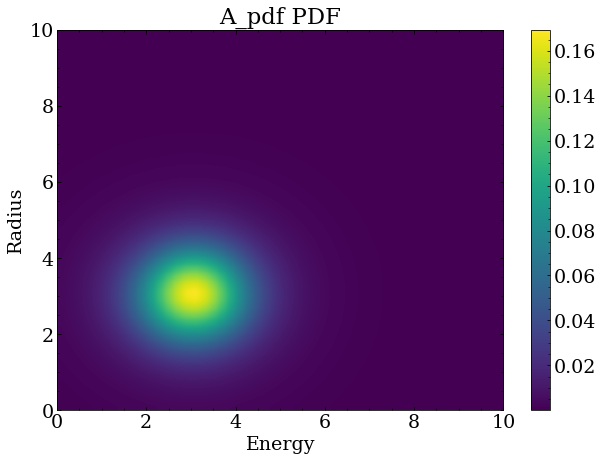

rough int 1.0030518720818995


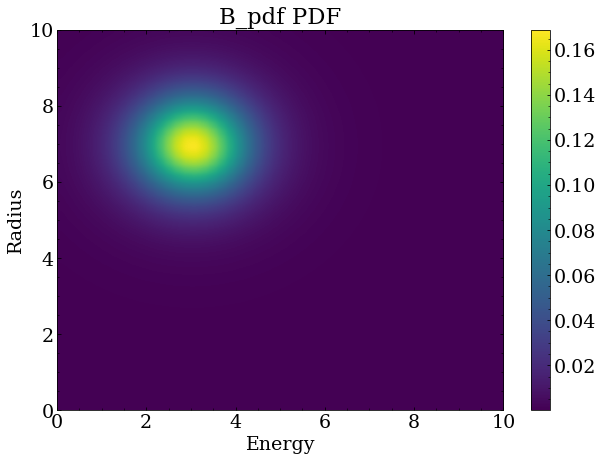

rough int 1.003063502141187


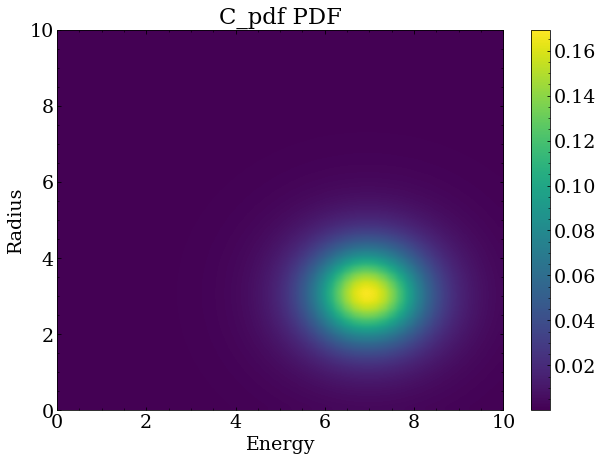

rough int 1.0030900051703837


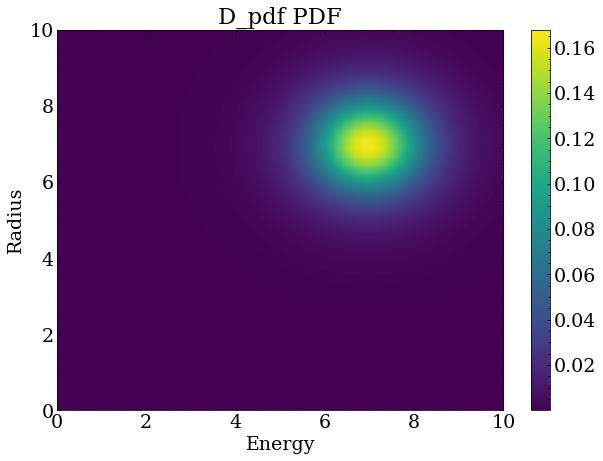

In [9]:
for s in obs.signals.values():
    Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
    X,Y = np.meshgrid(Xv,Yv)
    x_kj = list(zip(X.flatten(),Y.flatten()))
    Z = s.eval_pdf_multi(x_kj)
    print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
    Z = np.asarray(Z).reshape(X.shape)
    plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
    plt.colorbar()
    #plt.scatter(*(s.t_ij.T if np == cp else s.t_ij.T.get()),c='r',marker='x')
    plt.xlim(obs.lows[0],obs.highs[0])
    plt.ylim(obs.lows[1],obs.highs[1])
    plt.xlabel(obs.dimensions[0])
    plt.ylabel(obs.dimensions[1])
    plt.title('%s PDF'%s.name)
    plt.show()
    plt.close()

In [10]:
def gauss(x,m,s):
    return 1/np.sqrt(2*np.pi)/s*np.exp(-np.square((x-m)/s)/2)
from scipy.special import erf
def analytic_norm(energy,ewidth,radius,rwidth):
    a = obs.lows
    b = obs.highs
    m = np.asarray([energy,radius])
    s = np.asarray([ewidth,rwidth])
    d = 2
    return np.prod( erf((b-m)/s/np.sqrt(2)) - erf((a-m)/s/np.sqrt(2))  )/(2**d)
def analytic_pdf(x_kj,energy,ewidth,radius,rwidth):
    return gauss(x_kj[:,0],energy,ewidth)*gauss(x_kj[:,1],radius,rwidth)/analytic_norm(energy,ewidth,radius,rwidth)

rough int 0.0022297656797848433


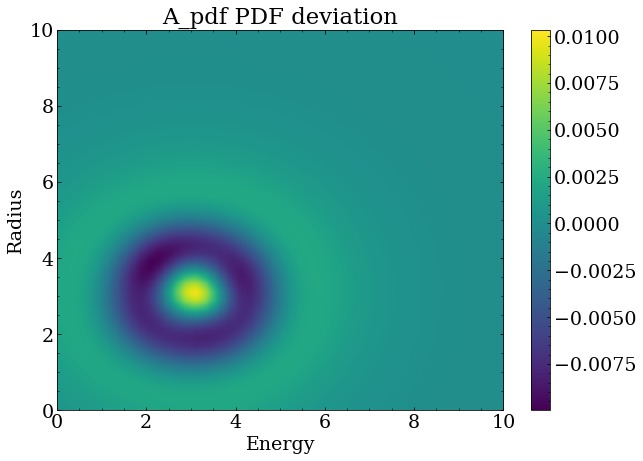

rough int 0.0022380570923196024


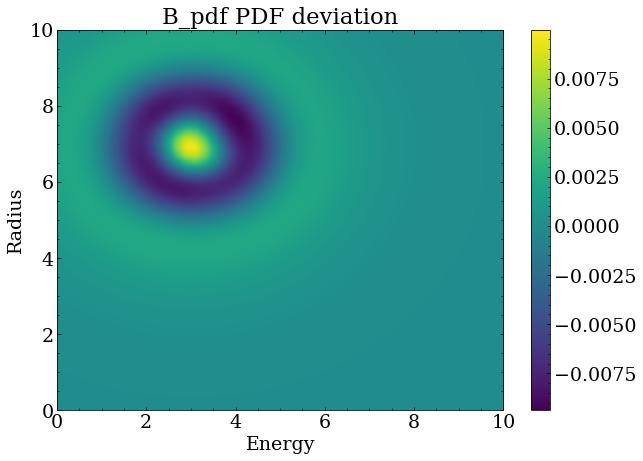

rough int 0.0022496871516068362


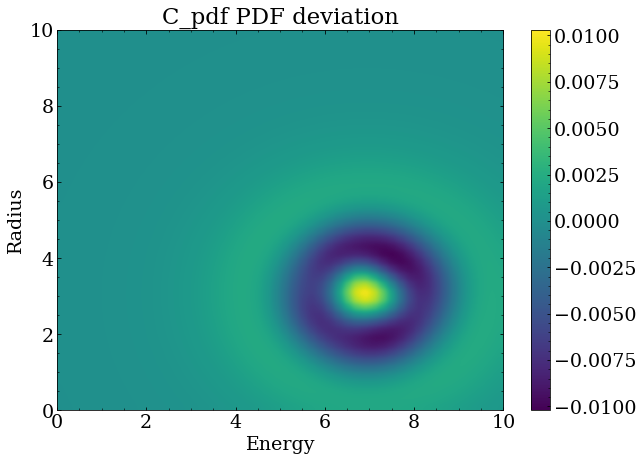

rough int 0.00227619018080387


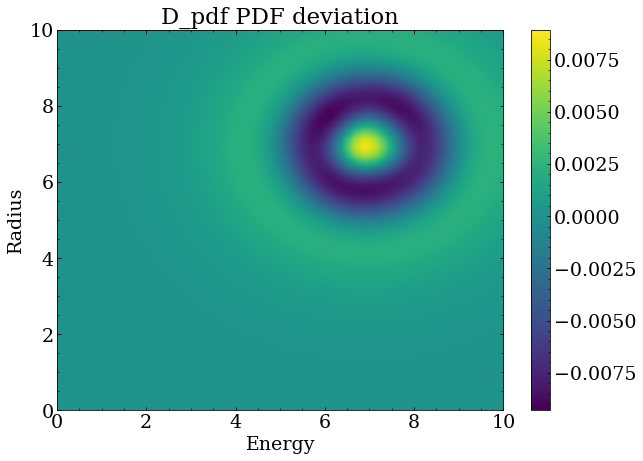

In [11]:
#The structure in the deviations is utterly bizarre to me
for j,s in enumerate(obs.signals.values()):
    name, weight, energy, ewidth, radius, rwidth = signals_mc_spec[j]
    Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
    X,Y = np.meshgrid(Xv,Yv)
    x_kj = np.asarray(list(zip(X.flatten(),Y.flatten())))
    Z = s.eval_pdf_multi(x_kj)
    analytic_Z = analytic_pdf(x_kj,energy,ewidth,radius,rwidth)
    Z = Z - analytic_Z
    print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
    Z = np.asarray(Z).reshape(X.shape)
    plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
    plt.colorbar()
    #plt.scatter(*(s.t_ij.T if np == cp else s.t_ij.T.get()),c='r',marker='x')
    plt.xlim(obs.lows[0],obs.highs[0])
    plt.ylim(obs.lows[1],obs.highs[1])
    plt.xlabel(obs.dimensions[0])
    plt.ylabel(obs.dimensions[1])
    plt.title('%s PDF deviation'%s.name)
    plt.show()
    plt.close()

rough int 1.0030550084771128


Text(0, 0.5, 'Radius')

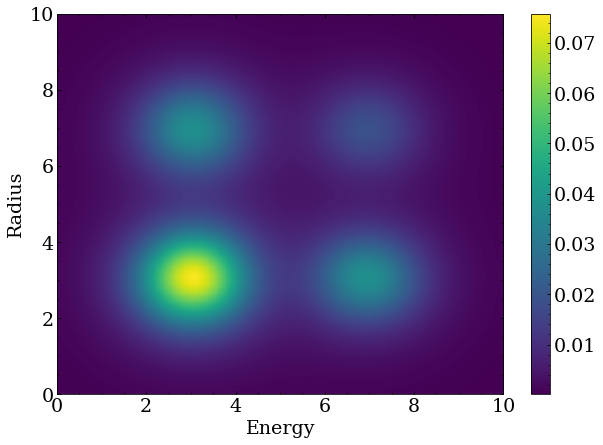

In [12]:
Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
X,Y = np.meshgrid(Xv,Yv)
x_kj = list(zip(X.flatten(),Y.flatten()))
Z = obs.eval_pdf_multi(x_kj)
print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
Z = np.asarray(Z).reshape(X.shape)
plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
plt.colorbar()    
#plt.scatter(*obs.x_ij.T,c='r',marker='x')
plt.xlim(obs.lows[0],obs.highs[0])
plt.ylim(obs.lows[1],obs.highs[1])
plt.xlabel(obs.dimensions[0])
plt.ylabel(obs.dimensions[1])

In [13]:
margs = dict(method='Nelder-Mead',options=dict(fatol=0.001,xatol=0.1))

In [14]:
%prun m = a.minimize(**margs)
print(m)

  final_simplex: (array([[236.10615709, 110.14654588, 108.41857751,  41.34303912],
       [236.10956057, 110.08408221, 108.48015037,  41.30548029],
       [236.1322679 , 110.13522246, 108.49782556,  41.35113471],
       [236.02937402, 110.13808483, 108.51087759,  41.33586216],
       [236.11579125, 110.08574966, 108.40343021,  41.3771302 ]]), array([49.2022472 , 49.202252  , 49.20225315, 49.20225981, 49.20226494]))
           fun: 49.20224719505211
       message: 'Optimization terminated successfully.'
          nfev: 85
           nit: 47
        params: {A_pdf_nev: 236.10615709477082, B_pdf_nev: 110.14654588054069, C_pdf_nev: 108.41857750584563, D_pdf_nev: 41.34303911996183}
        status: 0
       success: True
             x: array([236.10615709, 110.14654588, 108.41857751,  41.34303912])


Floated Parameters: [B_pdf_nev, C_pdf_nev, D_pdf_nev]
Fixed Parameters: [A_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


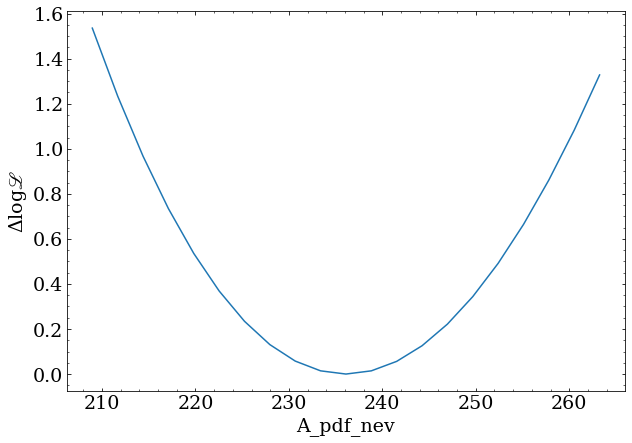

Floated Parameters: [A_pdf_nev, C_pdf_nev, D_pdf_nev]
Fixed Parameters: [B_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


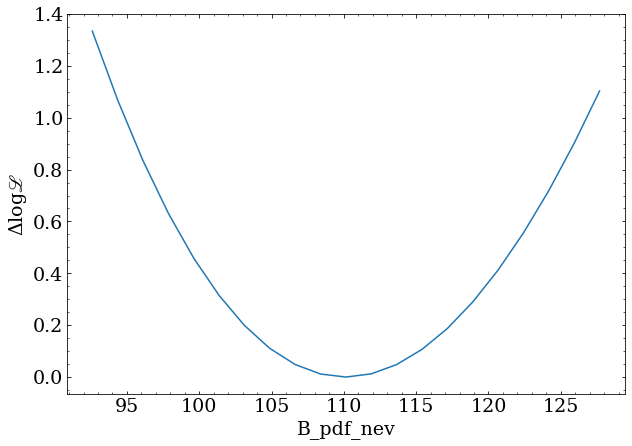

Floated Parameters: [A_pdf_nev, B_pdf_nev, D_pdf_nev]
Fixed Parameters: [C_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


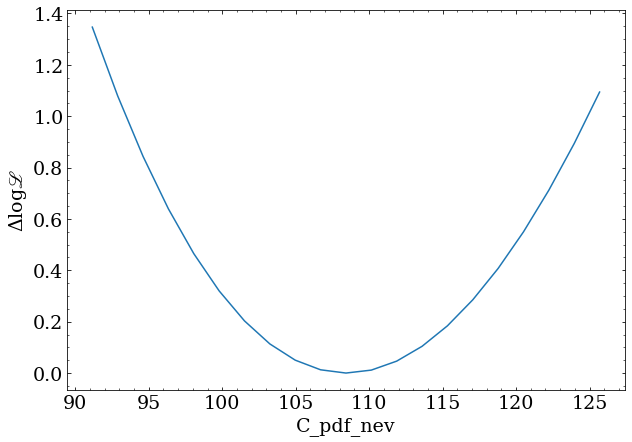

Floated Parameters: [A_pdf_nev, B_pdf_nev, C_pdf_nev]
Fixed Parameters: [D_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


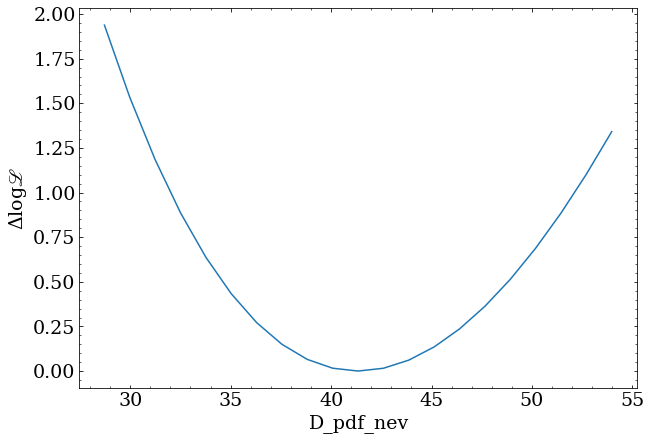

In [15]:
for _p,_v in m.params.items():
    _p.value = _v
    _p.fixed = False
for p,v in m.params.items():
    p.fixed = True
    a.update_likelihood(verbose=True)
    for step in np.logspace(-2,5,100):
        p.value = v*(1-step)
        if a() - m.fun < 1:
            continue
        p.value = v*(1+step)
        if a() - m.fun < 1:
            continue
        break
    X = np.linspace(v*(1-step),v*(1+step),21)
    Y = []
    for x in X:
        p.value = x
        nll = a() - m.fun
        Y.append(nll)
    p.fixed = False
    p.value = v
    plt.plot(X,Y)
    plt.xlabel(p.name)
    plt.ylabel(r'$\Delta$log$\scrL$')
    plt.show()
    plt.close()

In [16]:
%prun a.confidence_intervals(m,method='scan')
print(m)

  final_simplex: (array([[236.10615709, 110.14654588, 108.41857751,  41.34303912],
       [236.10956057, 110.08408221, 108.48015037,  41.30548029],
       [236.1322679 , 110.13522246, 108.49782556,  41.35113471],
       [236.02937402, 110.13808483, 108.51087759,  41.33586216],
       [236.11579125, 110.08574966, 108.40343021,  41.3771302 ]]), array([49.2022472 , 49.202252  , 49.20225315, 49.20225981, 49.20226494]))
           fun: 49.20224719505211
         lower: {A_pdf_nev: 15.752171935592742, B_pdf_nev: 10.972847212969441, C_pdf_nev: 10.727913778169878, D_pdf_nev: 6.756610960115587}
       message: 'Optimization terminated successfully.'
          nfev: 85
           nit: 47
        params: {A_pdf_nev: 236.10615709477082, B_pdf_nev: 110.14654588054069, C_pdf_nev: 108.41857750584563, D_pdf_nev: 41.34303911996183}
        status: 0
       success: True
         upper: {A_pdf_nev: 16.431463558778205, B_pdf_nev: 11.62017161840896, C_pdf_nev: 11.508634350753368, D_pdf_nev: 7.468229269333

In [ ]:
minima = []
for i in range(250):
    a.load_data(dict(Scint_Phase=NPYData('data_loader',['data/raw_data_%i.npy'%i],indexes=[0,1])))
    a.create_likelihood()
    m = a.minimize(**margs)
    m = a.confidence_intervals(m,method='scan')
    minima.append(m)
    print(m)

In [18]:
A_sig.nev_param.value = poisson_means[0]
A_sig.nev_param.fixed = False
B_sig.nev_param.value = poisson_means[1]
B_sig.nev_param.fixed = False
C_sig.nev_param.value = poisson_means[2]
C_sig.nev_param.fixed = False
D_sig.nev_param.value = poisson_means[3]
D_sig.nev_param.fixed = False
a.update_likelihood()
params = a._floated
central = np.asarray(poisson_means)

In [19]:
bias = np.asarray([[(m.params[p]-c)/c for p,c in zip(params,central)] for m in minima])

mean 0.016238529052399826 width 0.0781089391060326


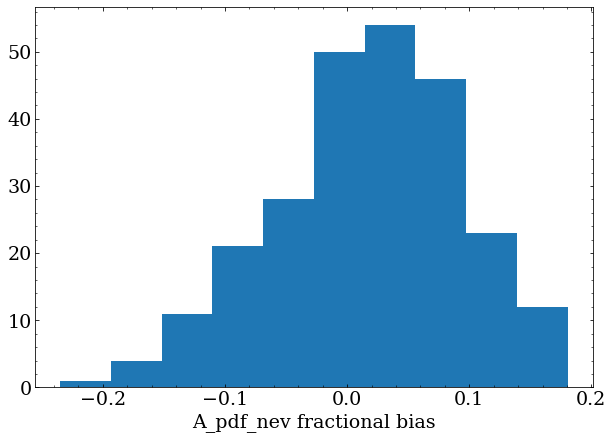

mean -0.008895576282566627 width 0.10951373480332975


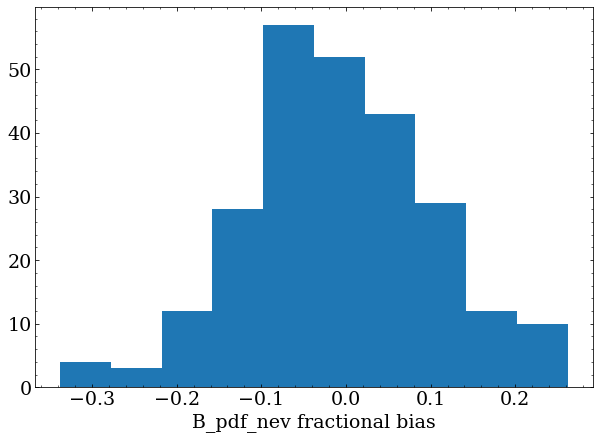

mean 0.002878965953642955 width 0.10538468023355642


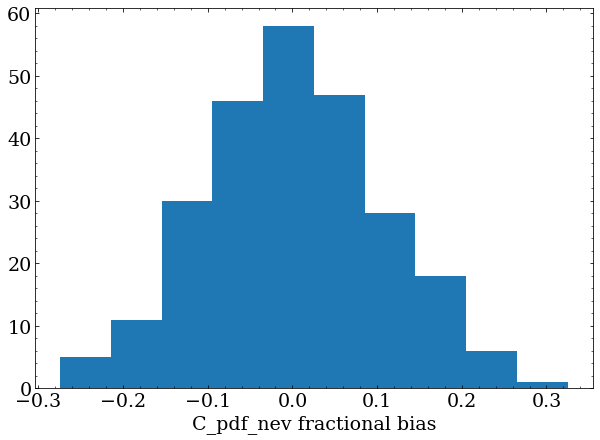

mean -0.0508827715348661 width 0.14531083456235905


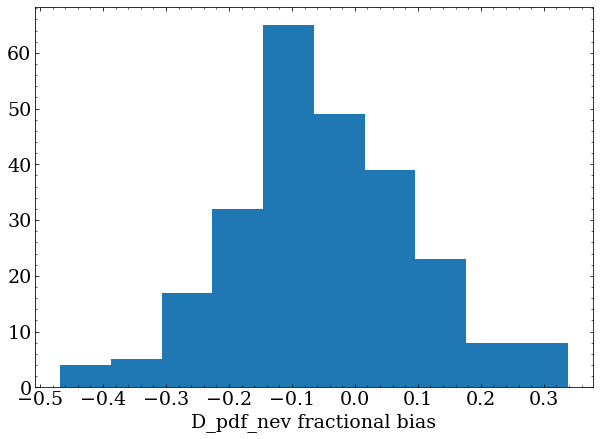

In [20]:
for p,b in zip(params,bias.T):
    print('mean',np.mean(b),'width',np.std(b))
    plt.hist(b)
    plt.xlabel('%s fractional bias'%p)
    plt.show()
    plt.close()

In [21]:
pull = np.asarray([[b/m.lower[p] if (b:=(m.params[p]-c)) < 0 else b/m.upper[p] for p,c in zip(params,central)] for m in minima])

0.15789251069497395 1.058817603571684


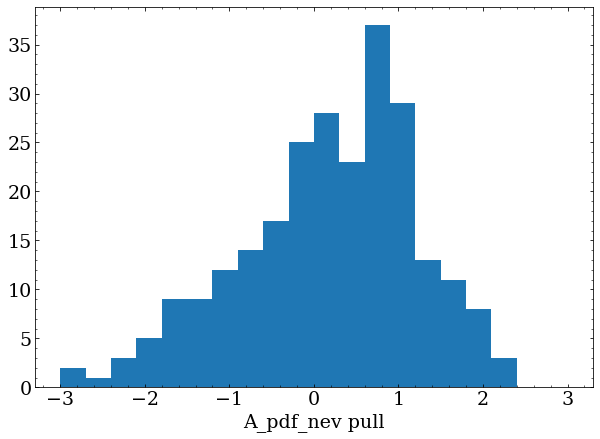

-0.16438345517516445 1.0561551613669313


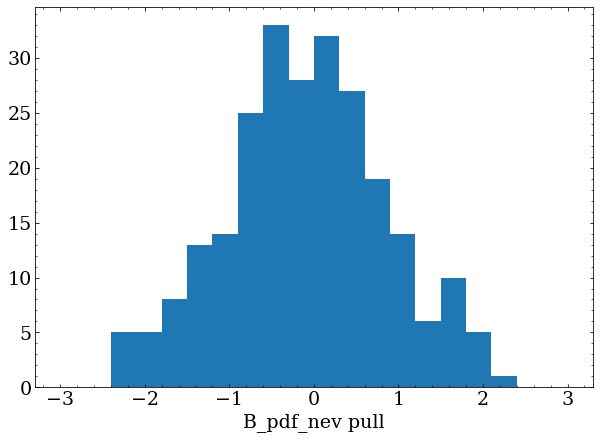

-0.04734075087995473 0.9916133450686387


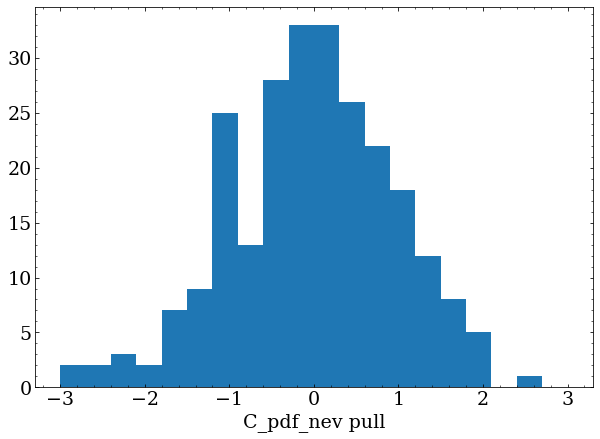

-0.44379883538104015 1.0229655649369631


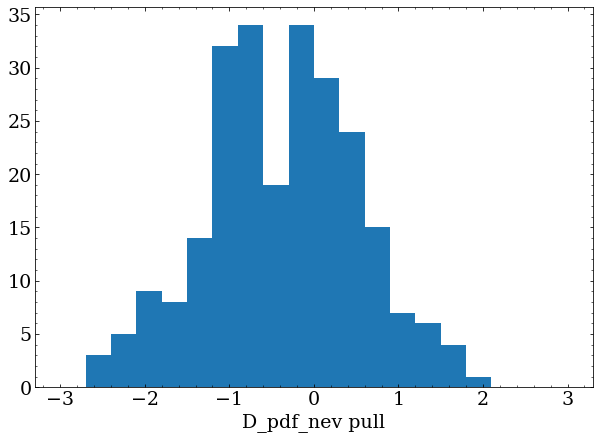

In [22]:
for p,u in zip(params,pull.T):
    print(np.mean(u),np.std(u))
    plt.hist(u,bins=np.linspace(-3,3,21))
    plt.xlabel('%s pull'%p)
    plt.show()
    plt.close()

Text(0, 0.5, 'Pull')

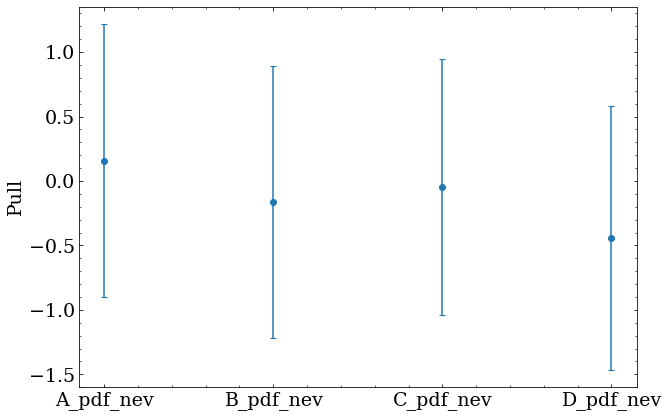

In [23]:
dat = np.asarray([(np.mean(u),np.std(u)) for u in pull.T])
par = np.arange(len(dat))
plt.errorbar(par,dat[:,0],yerr=dat[:,1],linestyle='none',marker='o')
plt.xticks(par,params)
plt.ylabel('Pull')

Text(0, 0.5, 'Bias')

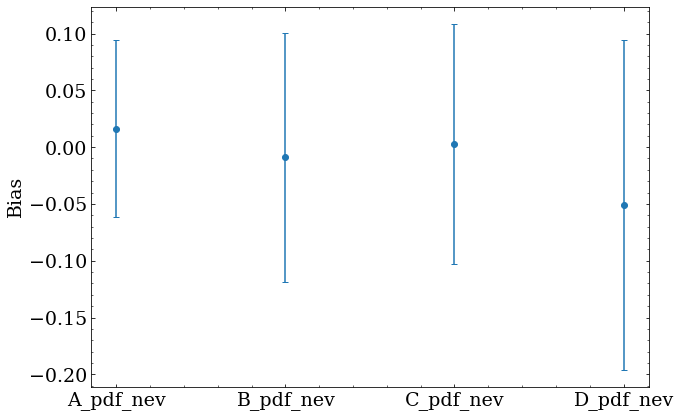

In [24]:
dat = np.asarray([(np.mean(u),np.std(u)) for u in bias.T])
par = np.arange(len(dat))
plt.errorbar(par,dat[:,0],yerr=dat[:,1],linestyle='none',marker='o')
plt.xticks(par,params)
plt.ylabel('Bias')